In [3]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# from google.colab.patches import cv2_imshow
from math import exp
import os 
from sklearn import svm
import joblib 

TUNING PARAMS

In [3]:
mean_filtering_kernel_dim = (3,3)
median_filtering_kernel_size = 3
std_deviation_for_gaussian_filtering = 4
n_std_dev = 4
segmentation_threshold_range = (100,200)
hsv_threshold_bound = [(0, 0,0), (40,255,255)]
opening_kernel_dim = (3,3)
closing_kernel_dim = (3,3)

UTILITY FUNCTIONS

In [4]:
def create_gaussian_kernel(std_dev, n_std_dev):
  kernel_size = int(n_std_dev*std_dev)+1
  k = np.arange(-kernel_size//2 +1, kernel_size//2+1, 1)
  one_d_kernel = 1/(2*np.pi*std_dev**2) * exp(-k**2/(2*std_dev))
  two_d_kernel = np.outer(one_d_kernel, one_d_kernel)
  return two_d_kernel

In [5]:
def euclidean_distance(point1, point2):
    return np.sqrt((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2)

In [6]:
def get_max(contour):
  M = cv2.moments(contour)
  if M['m00']!=0:
     cx = int(M['m10']/M['m00'])
     cy = int(M['m01']/M['m00'])
  else:
    cx,cy =0,0

  distances = []
  for point in contour:
    dist = euclidean_distance((cx, cy), point[0])
    distances.append(dist)

  return max(distances)

MAIN FUNCTIONS

In [7]:
def binarization(img):
  b,g,r = cv2.split(img)
  gray = 0.299*r + 0.587*g + 0.114*b
  gray_image = gray.astype(np.uint8)
  return gray_image

In [8]:
def image_enhancement(img, type="gaussian_filtering"):
  if type=="mean_filtering":
    enhanced_img = cv2.blur(img, mean_filtering_kernel_dim)

  elif type=="meadian_filtering":
    enhanced_img = cv2.medianBlur(img, median_filtering_kernel_size)

  elif type=="gaussian_filtering":
    # standard 2-D gaussian implementaion
    gaussian_filtering_kernel = (3,3)
    std_x, std_y = 1, 1
    enhanced_img = cv2.GaussianBlur(img, gaussian_filtering_kernel, std_x, std_y)
    # 1-D distance base gaussian used in the paper
    # kernel = create_gaussian_kernel(std_deviation_for_gaussian_filtering, n_std_dev)
    # enhanced_img = cv2.filter2D(img, -1, kernel)

  return enhanced_img

In [9]:
def image_segmentation(img=None, orig_img=None, type="hsv_thresholding"):
  if type=="binary_thresholding":
    segmented_img = np.zeros_like(img)
    segmented_img[(img>=segmentation_threshold_range[0]) & (img<=segmentation_threshold_range[1])] = 255

  elif type=="hsv_thresholding":
    hsv_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2HSV)
    mask=cv2.inRange(hsv_img, hsv_threshold_bound[0], hsv_threshold_bound[1])
    segmented_img = cv2.bitwise_and(img, img, mask=mask)

  return segmented_img

In [10]:
def morphology_treatment(img, type):
  # to close small holes in background
  if type =="opening":
    opening_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, opening_kernel_dim) #cv2.MORPH_RECT-rectangle kernel,
    #cv2.MORPH_ELLIPSE for elleptical kernel, and cv2.MORPH_CROSS for cross shaped kernel
    cleaned_img = cv2.morphologyEx(img, cv2.MORPH_OPEN, opening_kernel)
  # to close small holes in foreground
  if type =="closing":
    closing_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, closing_kernel_dim)
    cleaned_img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, closing_kernel)

  if type == "eroding":
    kernel = np.ones((5,5),np.uint8)
    cleaned_img = cv2.erode(img,kernel,iterations = 2)
    

  return cleaned_img

In [11]:
def calculate_shape_features(img, color_img):
  contours, _= cv2.findContours(img, cv2.RETR_EXTERNAL ,cv2.CHAIN_APPROX_NONE)
  feature_dict = {
      'coords':[],
      'area': [],
      'perimeter': [],
      'circularity' : [],
      'compactness': [],
      'rectangularity': [],
      'eccentricity': [],
      'b_mean':[],
      'g_mean':[],
      'r_mean':[],
      'h_mean':[],
      's_mean':[],
      'v_mean':[],
      'b_var':[],
      'g_var':[],
      'r_var':[],
      'h_var':[],
      's_var':[],
      'v_var':[]
  }
  hsv_img = cv2.cvtColor(color_img, cv2.COLOR_BGR2HSV)

  for contour in contours:
    area = cv2.contourArea(contour)
    x,y,w,h = cv2.boundingRect(contour)
    if area>500:
        perimeter = cv2.arcLength(contour, True)
        feature_dict['coords'].append((x,y,w,h))
        feature_dict['area'].append(area)
        feature_dict['perimeter'].append(perimeter)
        max_dist = get_max(contour)
        feature_dict['circularity'].append(area/(np.pi*max_dist**2))
        feature_dict['compactness'].append(perimeter**2/(4*np.pi*area))
        rect = cv2.minAreaRect(contour)
        best_fit_rect_area = rect[1][0]*rect[1][1]
        feature_dict['rectangularity'].append(area/best_fit_rect_area)
        ellipse = cv2.fitEllipse(contour)
        feature_dict['eccentricity'].append(min(ellipse[1])/max(ellipse[1]))
        # print(area)
    
        mask = np.zeros(img.shape, dtype=np.uint8)
        cv2.drawContours(mask, [contour], -1, 255, thickness=cv2.FILLED)
        # plt.imshow(mask)
    
        b_vals = color_img[:, :, 0][mask == 255]
        g_vals = color_img[:, :, 1][mask == 255]
        r_vals = color_img[:, :, 2][mask == 255]
        
        h_vals = hsv_img[:, :, 0][mask == 255]
        s_vals = hsv_img[:, :, 1][mask == 255]
        v_vals = hsv_img[:, :, 2][mask == 255]
    
        feature_dict['b_mean'].append(np.mean(b_vals))
        feature_dict['g_mean'].append(np.mean(g_vals))
        feature_dict['r_mean'].append(np.mean(r_vals))
        feature_dict['h_mean'].append(np.mean(h_vals))
        feature_dict['s_mean'].append(np.mean(s_vals))
        feature_dict['v_mean'].append(np.mean(v_vals))
        
        feature_dict['b_var'].append(np.var(b_vals))
        feature_dict['g_var'].append(np.var(g_vals))
        feature_dict['r_var'].append(np.var(r_vals))
        feature_dict['h_var'].append(np.var(h_vals))
        feature_dict['s_var'].append(np.var(s_vals))
        feature_dict['v_var'].append(np.var(v_vals))
  
  return pd.DataFrame(feature_dict)

In [12]:
# def draw_bounding_boxes(image, output_path=None):
#     contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
#     cv2.drawContours(image, contours, -1, (0, 255, 0), 5)
#     # for i, contour in enumerate(contours):
#     #     x, y, w, h = cv2.boundingRect(contour)
#     #     contour_img = cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 2)
#     #     print(i)
        
#     plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
#     plt.axis('off')
#     plt.show()

In [13]:
def preprocess(img):
  binarized_img = binarization(img.copy())
  # plt.imshow(binarized_img)
  enhanced_img = image_enhancement(binarized_img)
  # plt.imshow(enhanced_img)
  segmented_img = image_segmentation(img = enhanced_img, orig_img = img.copy())
  # plt.imshow(cv2.cvtColor(segmented_img)
  cleaned_img = morphology_treatment(segmented_img, type='eroding')
  # draw_bounding_boxes(cleaned_img)
  # plt.imshow(cleaned_img)
  # cleaned_img = morphology_treatment(segmented_img, 'opening')
  return cleaned_img

In [14]:
def watershed(image, debug=False):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # segmenting first layer
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    lower_color = np.array([40, 0, 0])
    upper_color = np.array([100, 255, 255])
    mask = cv2.inRange(hsv, lower_color, upper_color)
    inverse_mask = cv2.bitwise_not(mask)
    binary = image.copy()
    binary[inverse_mask != 0] = [255, 255, 255]
    binary[inverse_mask == 0] = [0, 0, 0]
    gray = cv2.cvtColor(binary, cv2.COLOR_RGB2GRAY)
    
    # remove noise with morphological operations
    kernel = np.ones((3, 3), np.uint8)
    opening = cv2.morphologyEx(gray, cv2.MORPH_OPEN, kernel, iterations=2)
    sure_bg = cv2.dilate(opening, kernel, iterations=3)
    
    # distance transform 
    dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
    _, sure_fg = cv2.threshold(dist_transform, 0.3 * dist_transform.max(), 255, 0)
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg, sure_fg)

    #watershed
    ret, markers = cv2.connectedComponents(sure_fg)
    markers = markers + 1
    markers[unknown == 255] = 0
    markers = cv2.watershed(image, markers)
    segmented_image = np.zeros_like(gray)
    segmented_image[markers > 1] = 255 
    kernel = np.ones((5,5),np.uint8)
    segmented_image = cv2.erode(segmented_image, kernel, iterations=1)

    if debug == True:
        # Find contours on the segmented image
        contours, _ = cv2.findContours(segmented_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        print(len(contours))
        img_copy = image.copy()
        cv2.drawContours(img_copy, contours, -1, (0, 255, 0), 2)
        phases = {
            'Original Image': image,
            'HSV Mask': mask,
            'Binary Image': binary,
            'Sure Background': sure_bg,
            'Distance Transform': dist_transform,
            'Sure Foreground': sure_fg,
            'Unknown Regions': unknown,
            'Markers': markers,
            'Segmented Objects': segmented_image,
            'Contours on Segmented Image': img_copy
        }
        plt.figure(figsize=(15, 10))
        
        for i, (phase_name, phase_image) in enumerate(phases.items(), 1):
            plt.subplot(3, 4, i)
            plt.title(phase_name)
            plt.axis('off')
            if len(phase_image.shape) == 2:
                plt.imshow(phase_image, cmap='gray')
            else:
                plt.imshow(phase_image)
        
        plt.tight_layout()
        plt.show()

    return segmented_image

In [15]:
def get_feature_df(img_path,watershed_bool=False):
  img = cv2.imread(img_path)
  if not watershed_bool:
      cleaned_img = preprocess(img)
  else:
      cleaned_img = watershed(img)
      
  df = calculate_shape_features(cleaned_img, img)
  return df
  # print(df.columns)

In [16]:
# get_feature_df('/content/Screenshot 2024-05-28 at 00.20.48.png')

In [17]:
def process_data(dir_path,watershed=False):

    columns = ['area', 'perimeter', 'circularity', 'compactness', 'rectangularity',
               'eccentricity', 'b_mean', 'g_mean', 'r_mean', 'h_mean', 's_mean',
               'v_mean', 'b_var', 'g_var', 'r_var', 'h_var', 's_var', 'v_var', 'label']
    
    main_df = pd.DataFrame(columns=columns)
    dir_names = os.listdir(dir_path)
    dir_names = [name for name in dir_names if name[0] != '.' and name!='test']
    print(dir_names)
    
    for dir_name in dir_names:
        dir_full_path = os.path.join(dir_path, dir_name)
        if os.path.isdir(dir_full_path):  
            imgs = os.listdir(dir_full_path)
            
            for img in imgs:
                img_full_path = os.path.join(dir_full_path, img)
                if os.path.isfile(img_full_path): 
                    new_df = get_feature_df(img_full_path)
                    # print(f'{img}: {len(new_df)}')
                    new_df['label'] = dir_name
                    main_df = pd.concat([main_df, new_df], ignore_index=True)

    return main_df

In [18]:
path_to_data = '/Users/sparsh/Desktop/wheat_new'
df = process_data(path_to_data, watershed)

['IDK', 'broken', 'KB', 'test_img.jpg', 'stones', 'other', 'shrivelled', 'good', 'test_dir', 'BT', 'Potia', 'model_1.joblib']


/var/folders/wz/8qqsdrnd54s2dqh65rgcy1l40000gn/T/ipykernel_84620/1214698031.py:23: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  main_df = pd.concat([main_df, new_df], ignore_index=True)


In [19]:
df

,area,perimeter,circularity,compactness,rectangularity,eccentricity,b_mean,g_mean,r_mean,h_mean,s_mean,v_mean,b_var,g_var,r_var,h_var,s_var,v_var,label,coords
0,10076.5,425.546244,0.472796,1.430125,0.753132,0.511910,51.852520,125.340092,156.153524,21.373916,170.357637,156.153524,83.226032,218.878294,413.331046,1.824121,91.785440,413.331046,IDK,"(2063, 2292, 143, 116)"
1,8676.0,407.019333,0.386516,1.519500,0.700553,0.451445,83.958437,158.180935,176.564491,24.247120,134.207251,176.581658,258.157523,167.725790,263.742791,4.122803,294.583544,262.606106,IDK,"(2063, 1684, 163, 80)"
2,8099.5,416.717817,0.289128,1.706146,0.717977,0.367574,61.897318,133.699082,154.925948,23.321334,153.846702,154.934404,191.256188,287.884201,448.451994,3.738494,172.583047,447.643801,IDK,"(2135, 1367, 95, 159)"
3,11114.0,431.504614,0.499957,1.333186,0.758516,0.578575,55.342918,132.253826,164.165708,21.392993,168.900380,164.165708,106.014939,205.523735,368.384024,2.006930,172.524624,368.384024,IDK,"(2004, 2273, 154, 103)"
4,9069.5,420.031525,0.431011,1.547999,0.732397,0.502991,78.830450,150.557093,172.288279,23.188906,138.984753,172.288279,230.325924,192.671913,134.064603,3.066715,327.112981,134.064603,IDK,"(2220, 1393, 136, 119)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290,8918.0,405.504614,0.389876,1.467284,0.715784,0.459737,79.102705,154.688586,194.936222,19.615681,151.415439,194.936222,83.873331,86.402252,170.380362,1.469959,116.124750,170.380362,Potia,"(1369, 2686, 165, 79)"
291,11606.5,444.090401,0.491677,1.352171,0.760779,0.517521,57.638536,139.143027,176.453398,20.784274,171.011693,176.453398,35.860871,154.935144,376.899243,2.501844,109.897338,376.899243,Potia,"(1285, 2682, 95, 168)"
292,11507.0,458.960458,0.404237,1.456728,0.712875,0.465944,79.222365,162.104476,195.365283,21.580899,151.143345,195.365624,51.529659,69.491135,221.576461,2.548086,121.136466,221.543407,Potia,"(1345, 3070, 187, 89)"
293,10665.0,437.445739,0.483862,1.427834,0.749781,0.502478,58.964338,132.311740,162.072060,21.486086,162.346664,162.072521,125.080649,350.869737,518.984302,2.474650,106.528184,518.935489,Potia,"(733, 2743, 141, 126)"


In [20]:
df.to_csv('/Users/sparsh/Desktop/wheat_data.csv')

In [20]:
# img_path = ''
# get_feature_df(img_path)

## TRAINING AND TESTING 

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

In [22]:
df = pd.read_csv('/Users/sparsh/Desktop/wheat_data.csv')
X= df.drop(columns=['label', 'coords'])
X= X.drop(df.columns[0], axis=1)
y = df['label'].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
pipeline = Pipeline([
    ('scaler', StandardScaler()), 
    ('svc', LinearSVC(C=1, max_iter=10000)) 
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

joblib.dump(pipeline, '/Users/sparsh/Desktop/wheat_new/model_1.joblib')
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          BT       0.31      0.57      0.40         7
         IDK       0.67      0.57      0.62        14
          KB       1.00      0.27      0.42        15
       Potia       0.39      1.00      0.56         7
      broken       1.00      0.88      0.93         8
        good       0.00      0.00      0.00         5
       other       1.00      1.00      1.00         5
  shrivelled       0.73      0.89      0.80         9
      stones       1.00      1.00      1.00         4
    test_dir       1.00      1.00      1.00        15

    accuracy                           0.70        89
   macro avg       0.71      0.72      0.67        89
weighted avg       0.76      0.70      0.68        89



/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is 

In [23]:
test_img_dir = '/Users/sparsh/Desktop/wheat_new/test/'
imgs = os.listdir(test_img_dir)

In [39]:
def annotate_test_img(img_path):
    img = cv2.imread(img_path)
    df = get_feature_df(img_path=img_path,watershed_bool=True)
    counter_dict = {
        'BT': 0,
        'IDK': 0,
        'KB': 0,
        'Potia': 0,
        'broken': 0,
        'good': 0,
        'other': 0,
        'shrivelled': 0,
        'stones': 0
    }
    for i, row in df.iterrows():
        val = row['coords']
        cv2.rectangle(img, (val[0], val[1]), (val[0]+val[2], val[1]+val[3]), (0,255,0), 3)
        x = row.drop(labels=['coords']).to_frame().T
        # print(x.columns)
        prediction = pipeline.predict(x)
        counter_dict[prediction[0]]+=1
        cv2.putText(img, f'{i}: {prediction[0]}', (val[0], val[1]-10), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 255, 0), 2)

    cv2.imwrite('/Users/sparsh/Desktop/wheat_new/test_img.jpg',img)
    print(counter_dict)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

{'BT': 4, 'IDK': 11, 'KB': 3, 'Potia': 12, 'broken': 4, 'good': 0, 'other': 5, 'shrivelled': 9, 'stones': 1}


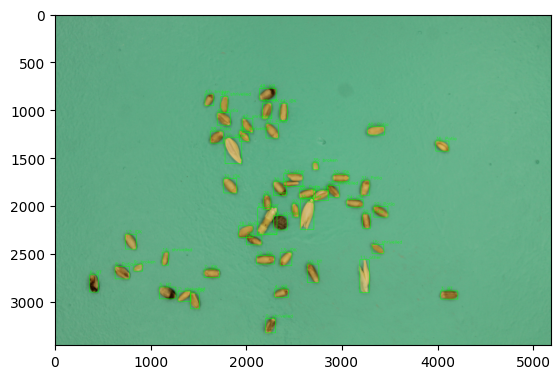

In [48]:
df = annotate_test_img('/Users/sparsh/Desktop/wheat_new/test/IMG_9987.JPG') ## change the test image file here 

In [86]:
def save_contour_regions(image, output_dir):
    cleaned_img = watershed(image)
    contours, _ = cv2.findContours(cleaned_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    for i, contour in enumerate(contours):
        x, y, w, h = cv2.boundingRect(contour)
        mask = np.zeros((h, w), dtype=np.uint8)
        cv2.drawContours(mask, [contour], -1, 255, thickness=cv2.FILLED, offset=(-x, -y))
        cropped_region = image_rgb[y:y+h, x:x+w]
        output_image = np.ones_like(cropped_region) * 255
        output_image[mask == 255] = cropped_region[mask == 255]
        # Save the output image
        output_image_path = os.path.join(output_dir, f'contour_{i}.png')
        cv2.imwrite(output_image_path, cv2.cvtColor(output_image, cv2.COLOR_RGB2BGR))

    print(f"Saved {len(contours)} contour regions to {output_dir}")

In [85]:
img = cv2.imread('/Users/sparsh/Desktop/wheat_new/test/IMG_9987.JPG')
save_contour_regions(img, '/Users/sparsh/Desktop/wheat_new/test_dir')

Saved 49 contour regions to /Users/sparsh/Desktop/wheat_new/test_dir


# NEURAL NETWORK 

In [4]:
from sklearn.preprocessing import LabelEncoder 
from tensorflow import keras 
import keras_tuner as kt 
from sklearn.model_selection import train_test_split

In [15]:
le = LabelEncoder()
df = pd.read_csv('/Users/sparsh/Desktop/wheat_data.csv')
df['label'] = le.fit_transform(df['label'])
df = df.drop(df.columns[:1], axis=1)
df = df.drop('coords', axis=1)
df = df.astype('float64')
df
X = df.drop('label', axis=1).values
y = df['label'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [33]:
def build_model(hp):
    model = keras.Sequential()
    model.add(keras.layers.Dense(
        units=hp.Int('units_1', min_value=32, max_value=512, step=32),
        activation='relu',
        input_shape=(X_train.shape[1],)
    ))
    model.add(keras.layers.Dense(
        units=hp.Int('units_2', min_value=32, max_value=512, step=32),
        activation='relu'
    ))
    model.add(keras.layers.Dense(
        units=hp.Int('units_3', min_value=32, max_value=512, step=32),
        activation='relu'
    ))
    model.add(keras.layers.Dense(len(le.classes_), activation='softmax'))

    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


In [34]:
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=50,
    hyperband_iterations=2,
    directory='my_dir',
    project_name='features_tuning_3'
)


In [ ]:
stop_early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath='/Users/sparsh/Desktop/wheat_new/best_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',  # Save the model with highest validation accuracy
    verbose=1
)

tuner.search(X_train, y_train, epochs=50, validation_split=0.2, callbacks=[stop_early, checkpoint_callback])


Trial 175 Complete [00h 07m 26s]
val_accuracy: 0.5208333134651184

Best val_accuracy So Far: 0.6041666865348816
Total elapsed time: 04h 36m 48s


In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected layer is {best_hps.get('units_1')}, 
in the second densely-connected layer is {best_hps.get('units_2')}, 
and in the third densely-connected layer is {best_hps.get('units_3')} 
with a learning rate of {best_hps.get('learning_rate')}.
""")

model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, y_train, epochs=50, validation_split=0.2, callbacks=[stop_early])


In [ ]:
eval_result = model.evaluate(X_test, y_test)
print(f"\nTest loss: {eval_result[0]} \nTest accuracy: {eval_result[1]}")
